In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Web Scrapping & Stock Recommendation**

#### Functionalities:

- Parse articles from the website "www.prnewswire.com".
- Store articles.
- Scan the articles to get stock symbols. 
- Retrieve market data using "Yahoo Finance API" for obtained stocks. 
- Create visualisations showing past 30-day fluctuations. 
- Provide stock recommendation.

In [ ]:
# BeautifulSoup documentation - https://beautiful-soup-4.readthedocs.io/en/latest/
# BeautifulSoup documentation @ pypi.org - https://pypi.org/project/beautifulsoup4/
# Yahoo! Finance's API documentation @ pypi.org - https://pypi.org/project/yfinance/
# Plotly - https://plotly.com/python-api-reference/
# Plotly @pypi - https://pypi.org/project/plotly/

In [2]:
# Please install these packages while initial run as these packages are not available in colab by default.


!pip install datefinder
!pip install yfinance

     |████████████████████████████████| 63 kB 1.7 MB/s 
     |████████████████████████████████| 6.4 MB 17.8 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [3]:
""" Importing all the necessary libraries/modules for the program."""

import re
import warnings
from collections import Counter
from datetime import datetime, timedelta
from typing import Tuple

import datefinder
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import requests
import tensorflow as tf
import yfinance as yf
from bs4 import BeautifulSoup
from tqdm import tqdm

warnings.filterwarnings("ignore")

In [4]:
# Initialize constants.

# Define the number of articles to be extracted each day from past 14 days.
# Note: Higher the number of articles, more time it takes to parse.

ARTICLES_TO_EXTRACT_PER_DAY = 5

## Scan/Parse

<p> This section generate links to get date wise news releases, generates links to articles and scan/parse articles from "newswire" website for the past two weeks. Stores the extracted data into a pandas DataFrame. </p>

In [5]:
class Parser:
    """
    Class with methods to generate links to news releases, links to articles, parse/scrape articles and extract required information.
    """

    def generate_links_for_date_wise_news_releases(self) -> list:
        """
        Method to generate a list of links that fetches news release of past two weeks.
        :return: list of links to get date wise news releases.
        """

        # Get start and end date to fetch articles.
        current_time = datetime.now()
        time_two_weeks_back = current_time - timedelta(days=13)
        print(f"\nParsing news from "
              + time_two_weeks_back.strftime("%m/%d/%Y %H:00")
              + " to " + current_time.strftime("%m/%d/%Y %H:00") + "\n")

        # Generate a list of links that shows news release of past two weeks.
        filtered_link_list = []
        for single_date in pd.date_range(time_two_weeks_back, current_time):
            filtered_link_list.append(f"https://www.prnewswire.com/news-releases/news-releases-list/"
                                      f"?page=1&pagesize={ARTICLES_TO_EXTRACT_PER_DAY}&month={single_date.month:02}"
                                      f"&day={single_date.day:02}&year={single_date.year:04}&hour={single_date.hour:02}")

        # Display links.
        for itr in filtered_link_list:
            print(itr)

        return filtered_link_list

    def generate_links_to_articles(self, filtered_news_links_list) -> list:
        """
        Method to generate a list of links to articles.

        :param filtered_news_links_list: list of links to news releases.
        :return articles_link_list: list of article links.
        """

        print("\n\nFetching links to articles from past two weeks..\n")

        # Looping through each date wise filtered news release links and fetching links to that days articles.
        articles_link_list = []
        for i in tqdm(filtered_news_links_list):
            response = requests.get(i)
            home_page = BeautifulSoup(response.text, 'html.parser')
            # Links to articles will be in the "a" tag with class "newsreleaseconsolidatelink display-outline".
            news_release_list = list(
                home_page.find_all("a", attrs={'class': 'newsreleaseconsolidatelink display-outline'}))
            # Adding all article links to one list.
            articles_link_list.extend(
                [f"https://www.prnewswire.com{i.attrs.get('href')}" for i in news_release_list if
                 i.attrs.get("href", "")])

        print("\n\nFetching complete.\n\n")

        # Display all article links.
        for itr in articles_link_list:
            print(itr)

        print(f"\n\nNumber of articles: {len(articles_link_list)}")

        return articles_link_list

    def parse_data_from_web(self, articles_link_list) -> pd.DataFrame:
        """
        Method to loop through article links, parse article body, date and add to dataframe.
        :param articles_link_list: list of links to articles.
        :return: Parsed data in dataframe.
        """

        print("\n\nExtracting information from scrapped content..\n")

        # Define dataframe.
        data = pd.DataFrame(columns=["url", "article_date", "article_content"])

        # Looping through article links and parsing, retrieving, storing information.
        for i in tqdm(articles_link_list):
            blog = requests.get(i)
            blog_soup = BeautifulSoup(blog.text, 'html.parser')
            # Article body is present in "section tag" with class "release-body container"
            blog_body = blog_soup.find("section", attrs={'class': 'release-body container'})
            if not blog_body:
                blog_body = blog_soup.find("section", attrs={'class': 'release-body container '})
            blog_body = blog_body.text if blog_body else ""

            # Fetch article date which is present in "meta" tag.
            blog_date = blog_soup.find("meta", attrs={'name': 'date'}).attrs.get("content", "")
            matches = list(datefinder.find_dates(blog_date))
            blog_date = str(matches[0]) if matches else ""

            # Append retrieved information to dataframe.
            data = data.append({
                "url": i,
                "article_date": blog_date,
                "article_content": blog_body},
                ignore_index=True)

        print("\n\nExtraction complete. All information added to dataframe.\n")

        return data

## Track/Store/Search

<p> This section keeps track of the news by storing the parsed news as XLSX.</p>

In [6]:
class Tracker:
    """
    Class to store extracted data in xlsx format and fetch stock tickers from it.
    """

    def __init__(self, data):
        self.data = data

    def store_data_as_excel(self) -> None:
        """
        Method to store data in dataframe as excel.
        :return None:
        """

        # Saving dataframe as excel with pandas to_excel function.
        self.data.to_excel(f"{datetime.now().strftime('%Y%m%d-%H%M%S')}_scrapped_data.xlsx", index=False)

    def preprocess_data(self) -> None:
        """
        Method to do preprocessing of data before extracting tickers.
        :return:
        """

        # Dropping duplicates if present.
        self.data.drop_duplicates(subset="article_content", inplace=True, ignore_index=True)

    def fetch_tickers(self) -> list:
        """
        Method to fetch tickers from all article content.
        :return: Set of tickers.
        """

        tickers = []
        for i in range(len(self.data)):

            # Find all ticker tokens in each parsed article content.
            tmp_ticker_tokens = re.findall(r':\s[A-Z]{1,5}[)]', self.data.iloc[i]["article_content"])

            # Using lambda function, loop through all extracted ticker tokens and convert to required format.
            tickers.extend(list(map(lambda x: x[-(len(x) - 2):-1], tmp_ticker_tokens)))

        return tickers

    def fetch_most_frequent_ticker(self, tickers) -> str:
        """
        Method to fetch most frequent ticker from all article content.
        :return: Set of tickers.
        """

        frequent_stock = ""
        if tickers:
            cnt = Counter(tickers)
            frequent_stock = cnt.most_common(1)[0][0] if cnt else ""
        else:
            print("No tickers found.")

        # Check if format is correct.
        if not isinstance(frequent_stock, str):
            raise Exception(f"Format error for 'frequent_stock' variable. Supposed to be 'str', instead got {type(frequent_stock)}")

        return frequent_stock

## Retrieve Data (Web API)

<p> This section contacts Yahoo! Finance's API with the selected stock symbols and retrieves the stock prices and volume for the last 30 days. </p>

In [7]:
class Retriever:
    """
    Class to retrieve stock information for tickers found in scrapped content.
    """

    def __init__(self, tickers):
        self.tickers = tickers

    def retrieve(self) -> Tuple[dict, list]:
        """
        Method to retrieve ticker prices using yahoo finance api.
        :return: Stock information as dict.
        """

        stocks = {}
        for tick in self.tickers:
            # If ticker info is unavailable to fetch from yahoo API, remove ticker from ticker list.
            if yf.Ticker(tick).history(period="YTD").empty:
                self.tickers.remove(tick)
            else:
                stocks[tick] = yf.Ticker(tick).history(period="YTD")

        return stocks, self.tickers

## Visualization

<p> This section prepares colorful visualization showing the stock prices which is plotted time-series with "Volume" & "Daily Close Price" features. </p>



In [8]:
class Visualizer:
    """
    Class to display visualization of stock information.
    """

    def __init__(self, stocks):
        self.stocks = stocks

    def generate_candle_stick_visualization(self, ticker, increasing_line, decreasing_line):
        fig = go.Figure(data=[go.Candlestick(
            x=self.stocks[ticker].index,
            open=self.stocks[ticker]['Open'],
            high=self.stocks[ticker]['High'],
            low=self.stocks[ticker]['Low'],
            close=self.stocks[ticker]['Close'],
            increasing_line_color=increasing_line,
            decreasing_line_color=decreasing_line)
            ])
        fig.update_layout(autosize=False,
                          width=1000,
                          height=800,)
        fig.show()

    def plot_tickers(self, ticker, index=0):
        fig = plt.figure(figsize=(30, 25))
        ax1 = plt.subplot(2, 2, 1)
        plt.title("Close Price", fontsize=25)
        plt.xlabel("Date", fontsize=25)
        plt.ylabel("Prie in USD", fontsize=25)
        plt.xticks(rotation=45)
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        ax2 = plt.subplot(2, 2, 2)
        plt.title("Volume", fontsize=25)
        plt.xticks(rotation=45)
        plt.xticks(fontsize=20)
        plt.xlabel("Date", fontsize=25)
        plt.ylabel("Shares per day", fontsize=25)
        plt.yticks(fontsize=20)
        ax2.yaxis.offsetText.set_fontsize(20)
        ax1.plot(self.stocks[ticker]["Close"][index:])
        ax2.plot(self.stocks[ticker]["Volume"][index:])
        plt.suptitle("Charts for " + ticker, fontsize=40)

## Recommending Stock's Purchase

<p> This section has the code to recommend if a stock is worth buying or not. </p>

In [9]:
MODEL_PATH = "/content/LSTM_model"

In [10]:
class StockRecommender:
    """
    Class to predict if a stock is worth purchasing.
    """

    def __init__(self, stocks):
        self.stocks = stocks

        # Loading stock recommendation model.
        self.model = tf.keras.models.load_model(f"{MODEL_PATH}")

    def model_predict(self, X):
        temp = self.model.predict(X)
        if 0.55 > temp[0][0] > 0.45:
            print("Wait before buying stock.")
        else:
            if np.argmax(self.model.predict(X)) == 0:
                print("Don't buy stock.")
            else:
                print("Buy stock.")

    def preprocess(self, ticker):
        series = self.stocks[ticker]["Close"]
        series = series[-31:]
        series = series.pct_change()
        series.dropna(inplace=True)
        X = np.array(series)
        return self.model_predict(X.reshape(1, X.shape[0], 1))

## Main

<p> Run all functions </p>

In [11]:
# Web scraping.

parser_obj = Parser()

date_wise_news_releases_links = parser_obj.generate_links_for_date_wise_news_releases()
articles_links = parser_obj.generate_links_to_articles(date_wise_news_releases_links)
data = parser_obj.parse_data_from_web(articles_links)

data


Parsing news from 02/26/2022 15:00 to 03/11/2022 15:00

https://www.prnewswire.com/news-releases/news-releases-list/?page=1&pagesize=5&month=02&day=26&year=2022&hour=15
https://www.prnewswire.com/news-releases/news-releases-list/?page=1&pagesize=5&month=02&day=27&year=2022&hour=15
https://www.prnewswire.com/news-releases/news-releases-list/?page=1&pagesize=5&month=02&day=28&year=2022&hour=15
https://www.prnewswire.com/news-releases/news-releases-list/?page=1&pagesize=5&month=03&day=01&year=2022&hour=15
https://www.prnewswire.com/news-releases/news-releases-list/?page=1&pagesize=5&month=03&day=02&year=2022&hour=15
https://www.prnewswire.com/news-releases/news-releases-list/?page=1&pagesize=5&month=03&day=03&year=2022&hour=15
https://www.prnewswire.com/news-releases/news-releases-list/?page=1&pagesize=5&month=03&day=04&year=2022&hour=15
https://www.prnewswire.com/news-releases/news-releases-list/?page=1&pagesize=5&month=03&day=05&year=2022&hour=15
https://www.prnewswire.com/news-release

100%|██████████| 14/14 [00:18<00:00,  1.34s/it]




Fetching complete.


https://www.prnewswire.com/news-releases/gato-class-action--kessler-topaz-meltzer--check-llp-reminds-gatos-silver-inc-shareholders-of-securities-fraud-class-action-lawsuit-301490595.html
https://www.prnewswire.com/news-releases/dmytro-firtash-opposes-russian-invasion-asks-to-be-allowed-to-return-to-ukraine-now-without-changing-status-quo-regarding-us-legal-charges-against-him-according-to-an-attorney-on-us-legal-team-lanny-j-davis-301491057.html
https://www.prnewswire.com/news-releases/dar-al-arkan-enthullt-w-residences-dubai-downtown-mit-blick-auf-dubais-burj-khalifa-und-dubai-fountain-800599150.html
https://www.prnewswire.com/news-releases/dar-al-arkan-devoile-le-w-residences-dubai-downtown-avec-vue-sur-le-burj-khalifa-et-la-fontaine-de-dubai-862501704.html
https://www.prnewswire.com/news-releases/united-launch-alliance-set-to-launch-goes-t-mission-for-noaa-and-nasa-301491045.html
https://www.prnewswire.com/news-releases/spwr-equity-alert-rosen-a-top-ranked-law

100%|██████████| 70/70 [00:26<00:00,  2.60it/s]



Extraction complete. All information added to dataframe.



,url,article_date,article_content
0,https://www.prnewswire.com/news-releases/gato-...,2022-02-26 14:04:00-05:00,"\n\n\nRADNOR, Pa., Feb. 26, 2022 /PRNewswire/ ..."
1,https://www.prnewswire.com/news-releases/dmytr...,2022-02-26 13:46:00-05:00,"\n\n\nWASHINGTON, Feb. 26, 2022 /PRNewswire/ -..."
2,https://www.prnewswire.com/news-releases/dar-a...,2022-02-26 12:31:00-05:00,"\n\n\nDUBAI, VAE, 26. Februar 2022 /PRNewswire..."
3,https://www.prnewswire.com/news-releases/dar-a...,2022-02-26 12:27:00-05:00,"\n\n\nDUBAI, EAU, 26 février 2022 /PRNewswire/..."
4,https://www.prnewswire.com/news-releases/unite...,2022-02-26 12:21:00-05:00,"\n\n\nCAPE CANAVERAL SPACE FORCE STATION, Fla...."
...,...,...,...
65,https://www.prnewswire.com/news-releases/id-in...,2022-03-11 10:53:00-05:00,"\n\n\nMINNEAPOLIS, March 11, 2022 /PRNewswire/..."
66,https://www.prnewswire.com/news-releases/disco...,2022-03-11 10:51:00-05:00,"\n\n\nNEW YORK, March 11, 2022 /PRNewswire/ --..."
67,https://www.prnewswire.com/news-releases/globa...,2022-03-11 10:50:00-05:00,"\n\n\nSAN FRANCISCO, March 11, 2022 /PRNewswir..."
68,https://www.prnewswire.com/news-releases/globa...,2022-03-11 10:50:00-05:00,"\n\n\nSAN FRANCISCO, March 11, 2022 /PRNewswir..."


In [12]:
# Tracking: storing data and generating tickers.

tracker_obj = Tracker(data)

tracker_obj.store_data_as_excel()
tracker_obj.preprocess_data()
tickers = tracker_obj.fetch_tickers()

tickers

['GATO',
 'SPWR',
 'OIII',
 'OIIIF',
 'OIII',
 'OIIIF',
 'VERB',
 'FHN',
 'REGI',
 'IIN',
 'HTA',
 'HR',
 'APR',
 'RCM',
 'SKIL',
 'SMFR',
 'LDI',
 'ELMS',
 'EDU',
 'CABA',
 'BFLY',
 'CLVT',
 'GT',
 'SBSAA',
 'WY']

In [14]:
# Retrieving stock info.

retriever_obj = Retriever(tickers)

stocks, tickers = retriever_obj.retrieve()
# print("\nStock Information:\n", stocks)

try:
    common_ticker = tracker_obj.fetch_most_frequent_ticker(tickers)

except Exception as err:
    common_ticker = ""
    print("\nERROR:", str(err))

In [15]:
# Visualization

visualizer_obj = Visualizer(stocks)

i_cl = ["gold", "green", "cyan"]
d_cl = ["gray", "red", "black"]

widgets.interact(visualizer_obj.generate_candle_stick_visualization, ticker=stocks.keys(), increasing_line=i_cl, decreasing_line=d_cl)

widgets.interact(visualizer_obj.plot_tickers, ticker=stocks.keys())

interactive(children=(Dropdown(description='ticker', options=('GATO', 'SPWR', 'OIIIF', 'VERB', 'FHN', 'REGI', …

interactive(children=(Dropdown(description='ticker', options=('GATO', 'SPWR', 'OIIIF', 'VERB', 'FHN', 'REGI', …

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>>

In [16]:
# Stock recommendation

stock_recommender_obj = StockRecommender(stocks)

widgets.interact(stock_recommender_obj.preprocess, ticker=stocks.keys())

interactive(children=(Dropdown(description='ticker', options=('GATO', 'SPWR', 'OIIIF', 'VERB', 'FHN', 'REGI', …

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>>

Buy stock.


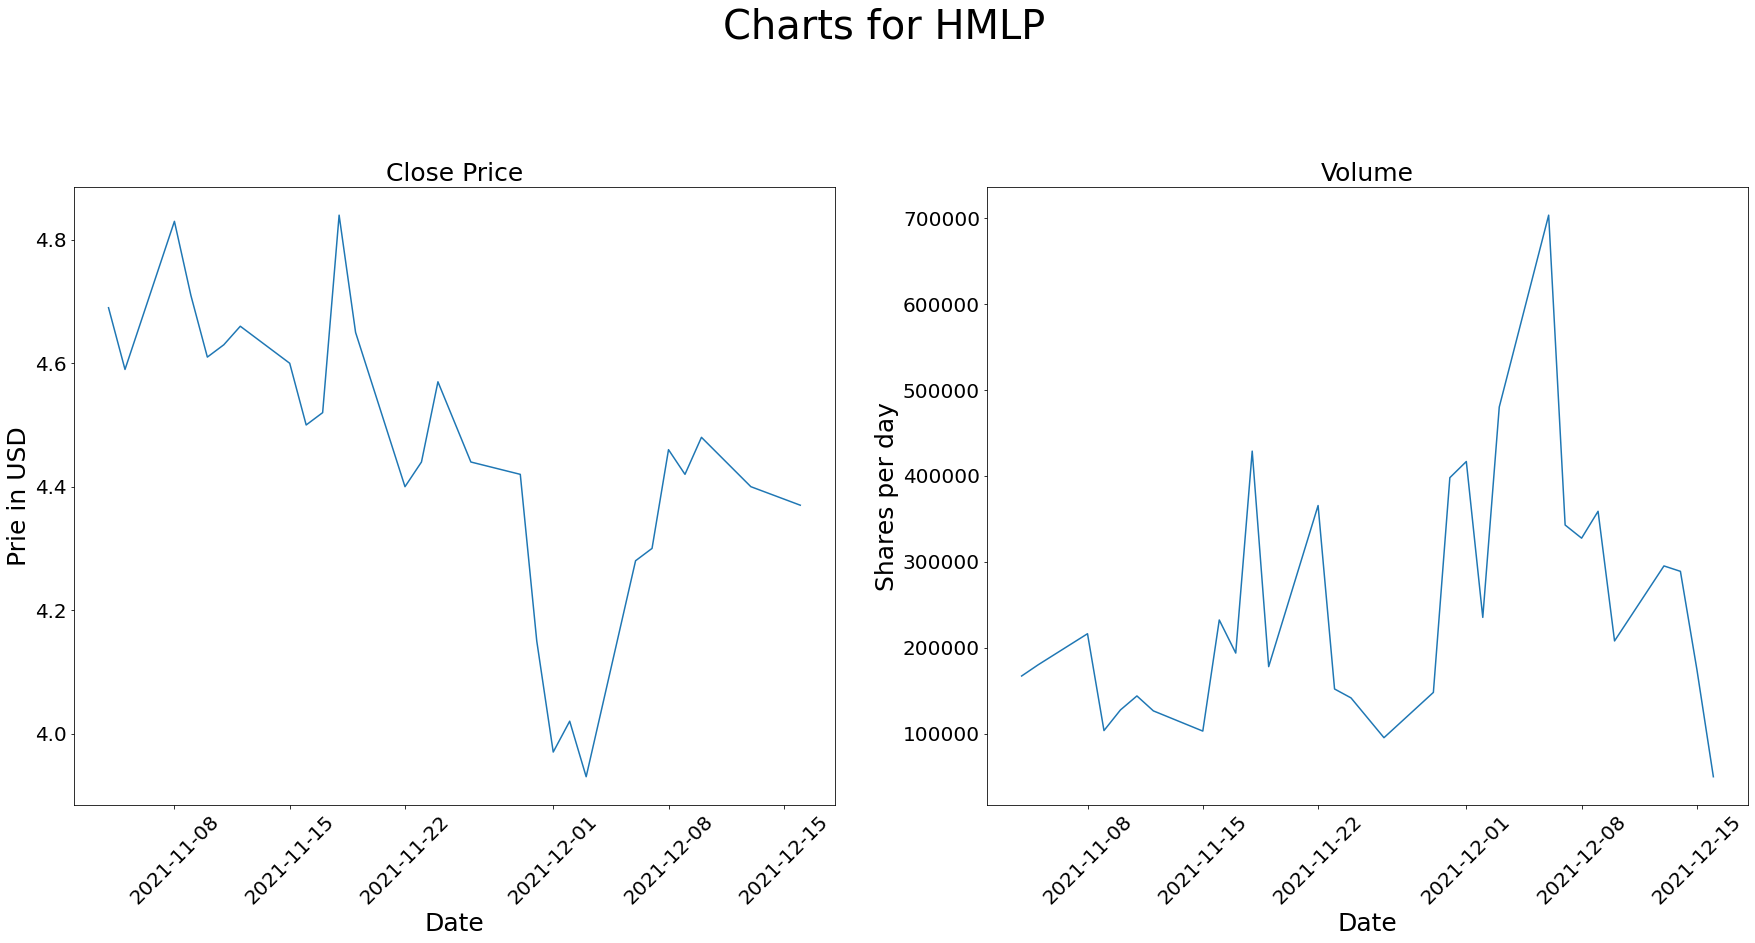

In [ ]:
# Show recommendation and visualization for most frequent stock symbol.

if common_ticker:
    stock_recommender_obj.preprocess(common_ticker)
    visualizer_obj.plot_tickers(common_ticker, index=-30)
else:
    print("\nERROR: common ticker not available.")